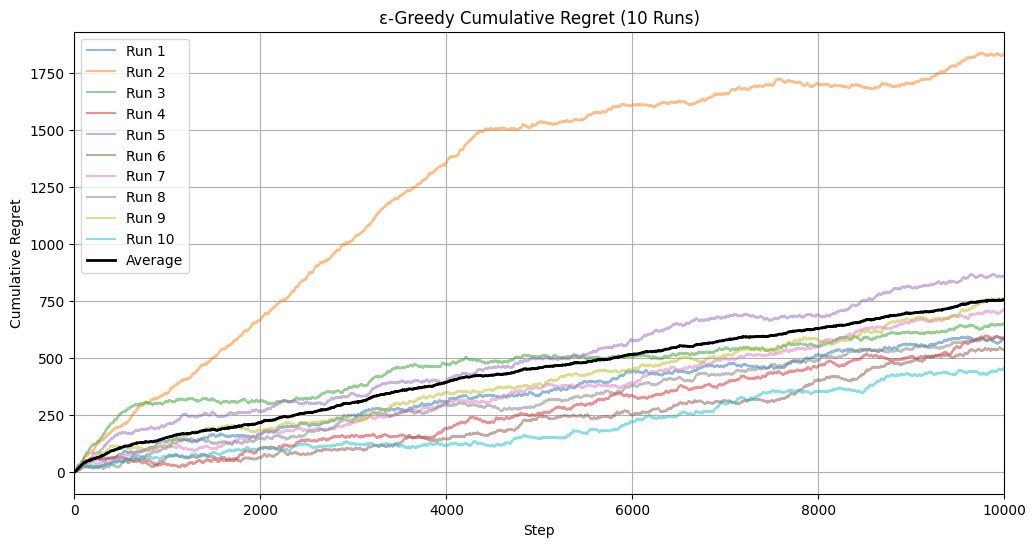

In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Load data
ratings = pd.read_csv('ratings.dat', sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies = pd.read_csv('movies.dat', sep='::', engine='python', names=['MovieID', 'Title', 'Genres'], encoding='latin-1')

# Extract the primary genre for each movie
movies['PrimaryGenre'] = movies['Genres'].str.split('|').str[0]

# Merge ratings and movies datasets
merged_data = pd.merge(ratings, movies, on='MovieID')

# Select Rating and PrimaryGenre columns
rating_genres_data = merged_data[['Rating', 'PrimaryGenre']]

# Get all unique genres
unique_genres = rating_genres_data['PrimaryGenre'].unique()

# Group by genres and create a dictionary to store ratings for each genre
genre_ratings = {genre: rating_genres_data[rating_genres_data['PrimaryGenre'] == genre]['Rating'].tolist() for genre in unique_genres}

# ε-Greedy strategy
def epsilon_greedy(K, n, reward_lists, epsilon=0.1):
    np.random.seed(int(time.time()))
    random.seed(time.time())
    
    # Initialize variables
    T = np.zeros(K)  # Number of times each arm has been pulled
    reward_sums = np.zeros(K)  # Sum of rewards for each arm
    estimated_means = np.zeros(K)  # Estimated mean reward for each arm
    cumulative_regrets = np.zeros(n)  # Cumulative regrets over time
    optimal_mean = max(np.mean(reward_list) for reward_list in reward_lists)  # True optimal mean
    
    for t in range(n):
        if random.random() < epsilon:
            # Exploration: Choose a random arm
            chosen_arm = random.randint(0, K-1)
        else:
            # Exploitation: Choose the arm with the highest estimated mean
            chosen_arm = np.argmax(estimated_means)
        
        # Pull the chosen arm and get the reward
        reward = random.choice(reward_lists[chosen_arm])
        
        # Update the statistics for the chosen arm
        T[chosen_arm] += 1
        reward_sums[chosen_arm] += reward
        estimated_means[chosen_arm] = reward_sums[chosen_arm] / T[chosen_arm]
        
        # Calculate the regret for this step
        cumulative_regrets[t] = optimal_mean - reward
    
    # Calculate cumulative regrets
    cumulative_regrets = np.cumsum(cumulative_regrets)
    
    return cumulative_regrets

# Example parameters
K = len(unique_genres)  # Number of arms (primary genres)
n = 10000  # Total time steps
reward_lists = list(genre_ratings.values())  # Use all genres' ratings as reward lists

# Run ε-Greedy algorithm ten times
epsilon = 0.1  # Exploration probability
num_runs = 10
all_cumulative_regrets = np.zeros((num_runs, n))

for run in range(num_runs):
    cumulative_regrets = epsilon_greedy(K, n, reward_lists, epsilon)
    all_cumulative_regrets[run, :] = cumulative_regrets

# Calculate average cumulative regret
mean_cumulative_regrets = np.mean(all_cumulative_regrets, axis=0)

# Plot cumulative regrets for each run and the average
plt.figure(figsize=(12, 6))

# Plot each run
for run in range(num_runs):
    plt.plot(all_cumulative_regrets[run, :], label=f'Run {run + 1}', alpha=0.5)

# Plot average cumulative regret
plt.plot(mean_cumulative_regrets, label='Average', color='black', linewidth=2)

plt.title('ε-Greedy Cumulative Regret (10 Runs)')
plt.xlabel("Step")
plt.ylabel("Cumulative Regret")
plt.xlim(0, n)
plt.legend()
plt.grid(True)
plt.show()